In [72]:
# Setup: imports and paths
import os
import pandas as pd
import numpy as np

pd.set_option('display.max_columns', None)
# Resolve raw and clean paths robustly relative to working directory
RAW_CANDIDATES = [
    os.path.join('data', 'koi.csv'),
    os.path.join('..', 'data', 'koi.csv'),
]
RAW_PATH = next((p for p in RAW_CANDIDATES if os.path.isfile(p)), RAW_CANDIDATES[0])
DATA_DIR = os.path.dirname(RAW_PATH) if os.path.basename(RAW_PATH) else os.path.join('data')
CLEAN_PATH = os.path.join(DATA_DIR, 'koi_clean.csv')

In [73]:
# Column groups (kept consistent with the framework)
IDENTIFIER_COLS = [
    'kepid',            # Kepler Catalog ID
    'kepoi_name',       # KOI Name
    'kepler_name',      # Official Kepler Planet Name (if any)
]

TARGET_COL = 'koi_score'

LABEL_COLS = [
    'koi_disposition',     # Exoplanet Archive Disposition
    'koi_pdisposition',    # Disposition Using Kepler Data
    'koi_fpflag_nt',       # Not Transit-Like FP flag
    'koi_fpflag_ss',       # Stellar Eclipse FP flag
    'koi_fpflag_co',       # Centroid Offset FP flag
    'koi_fpflag_ec',       # Ephemeris Match FP flag
]

FEATURE_COLS = [
    # 1) Transit geometry & signal quality
    'koi_period', 'koi_impact', 'koi_duration', 'koi_depth', 'koi_model_snr',
    # 2) Planet properties & irradiation
    'koi_prad', 'koi_teq', 'koi_insol',
    # 3) Stellar properties
    'koi_steff', 'koi_slogg', 'koi_srad',
    # 4) Brightness (observation quality)
    'koi_kepmag',
]

# Always drop from feature matrix (metadata), per framework
DROP_ALWAYS = ['koi_tce_plnt_num', 'koi_tce_delivname']

ALL_KEEP_COLS = IDENTIFIER_COLS + [TARGET_COL] + LABEL_COLS + FEATURE_COLS

In [74]:
def clean_koi(raw_path: str, out_path: str) -> pd.DataFrame:
    """
    Load raw KOI CSV, select relevant columns, enforce basic validity of koi_score,
    and save a clean CSV for downstream use.
    """
    # Load raw CSV; ignore NASA header comments starting with '#'
    df = pd.read_csv(raw_path, comment='#', low_memory=False)
    orig_rows = len(df)
    df.columns = df.columns.str.strip()

    # Keep only the specified columns if present
    keep_cols = [c for c in ALL_KEEP_COLS if c in df.columns]
    df = df.loc[:, keep_cols].copy()

    # Drop exact duplicate rows
    before_dupes = len(df)
    df = df.drop_duplicates()
    dropped_dupes = before_dupes - len(df)

    # Coerce numeric columns
    numeric_cols = set(FEATURE_COLS + [TARGET_COL, 'kepid'])
    numeric_cols.update([c for c in LABEL_COLS if c.startswith('koi_fpflag_')])
    numeric_cols = [c for c in numeric_cols if c in df.columns]
    for c in numeric_cols:
        df[c] = pd.to_numeric(df[c], errors='coerce')

    # Remove rows with missing target
    before_drop_y_na = len(df)
    df = df.dropna(subset=[TARGET_COL])
    dropped_y_na = before_drop_y_na - len(df)

    # Enforce koi_score within [0, 1]
    before_range = len(df)
    mask_valid = (df[TARGET_COL] >= 0.0) & (df[TARGET_COL] <= 1.0)
    df = df.loc[mask_valid].copy()
    dropped_out_of_range = before_range - len(df)

    # Normalize string columns
    for c in ['kepoi_name', 'kepler_name', 'koi_disposition', 'koi_pdisposition']:
        if c in df.columns:
            df[c] = df[c].astype('string').str.strip()

    # Save clean CSV
    os.makedirs(os.path.dirname(out_path), exist_ok=True)
    df.to_csv(out_path, index=False)

    print(f'Loaded rows: {orig_rows}')
    print(f'Dropped exact duplicates: {dropped_dupes}')
    print(f'Dropped missing koi_score: {dropped_y_na}')
    print(f'Dropped out-of-range koi_score: {dropped_out_of_range}')
    print(f'Kept columns ({len(keep_cols)}): {keep_cols}')
    print(f'Final shape: {df.shape}')
    print(f'Saved to: {out_path}')
    return df

# Run cleaning once to produce data/koi_clean.csv
FORCE_REBUILD = False  # set True to overwrite existing clean file if needed
if FORCE_REBUILD or (not os.path.exists(CLEAN_PATH)):
    _df_clean = clean_koi(RAW_PATH, CLEAN_PATH)
else:
    print(f'Clean file already exists at {CLEAN_PATH}. Set FORCE_REBUILD=True and re-run this cell to rebuild.')

Clean file already exists at ..\data\koi_clean.csv. Set FORCE_REBUILD=True and re-run this cell to rebuild.


In [75]:
# Load the cleaned dataset
import os
import pandas as pd

CLEAN_CANDIDATES = [
    os.path.join('data', 'koi_clean.csv'),
    os.path.join('..', 'data', 'koi_clean.csv'),
]
CLEAN_PATH = next((p for p in CLEAN_CANDIDATES if os.path.isfile(p)), CLEAN_CANDIDATES[0])
df = pd.read_csv(CLEAN_PATH, low_memory=False)

# Re-declare column groups for standalone use of this cell onward
IDENTIFIER_COLS = ['kepid', 'kepoi_name', 'kepler_name']
TARGET_COL = 'koi_score'
LABEL_COLS = ['koi_disposition','koi_pdisposition','koi_fpflag_nt','koi_fpflag_ss','koi_fpflag_co','koi_fpflag_ec']
FEATURE_COLS = [
    'koi_period','koi_impact','koi_duration','koi_depth','koi_model_snr',
    'koi_prad','koi_teq','koi_insol','koi_steff','koi_slogg','koi_srad','koi_kepmag'
]

print(f'Loaded clean dataset: {df.shape[0]} rows x {df.shape[1]} columns')
df.head()

Loaded clean dataset: 8054 rows x 25 columns


,kepid,kepoi_name,kepler_name,koi_score,koi_disposition,koi_pdisposition,koi_fpflag_nt,koi_fpflag_ss,koi_fpflag_co,koi_fpflag_ec,koi_period,koi_time0bk,koi_impact,koi_duration,koi_depth,koi_model_snr,koi_prad,koi_teq,koi_insol,koi_steff,koi_slogg,koi_srad,ra,dec,koi_kepmag
0,10797460,K00752.01,Kepler-227 b,1.000,CONFIRMED,CANDIDATE,0,0,0,0,9.488036,170.538750,0.146,2.95750,615.8,35.8,2.26,793.0,93.59,5455.0,4.467,0.927,291.93423,48.141651,15.347
1,10797460,K00752.02,Kepler-227 c,0.969,CONFIRMED,CANDIDATE,0,0,0,0,54.418383,162.513840,0.586,4.50700,874.8,25.8,2.83,443.0,9.11,5455.0,4.467,0.927,291.93423,48.141651,15.347
2,10811496,K00753.01,NaN,0.000,CANDIDATE,CANDIDATE,0,0,0,0,19.899140,175.850252,0.969,1.78220,10829.0,76.3,14.60,638.0,39.30,5853.0,4.544,0.868,297.00482,48.134129,15.436
3,10848459,K00754.01,NaN,0.000,FALSE POSITIVE,FALSE POSITIVE,0,1,0,0,1.736952,170.307565,1.276,2.40641,8079.2,505.6,33.46,1395.0,891.96,5805.0,4.564,0.791,285.53461,48.285210,15.597
4,10854555,K00755.01,Kepler-664 b,1.000,CONFIRMED,CANDIDATE,0,0,0,0,2.525592,171.595550,0.701,1.65450,603.3,40.9,2.75,1406.0,926.16,6031.0,4.438,1.046,288.75488,48.226200,15.509


Skipped discrete/binary columns: []
Log10 columns: ['koi_period', 'koi_duration', 'koi_prad', 'koi_teq', 'koi_insol', 'koi_srad']
Log10(1+x) columns: ['koi_depth', 'koi_model_snr']
Linear columns: ['koi_impact', 'koi_steff', 'koi_slogg', 'koi_kepmag']


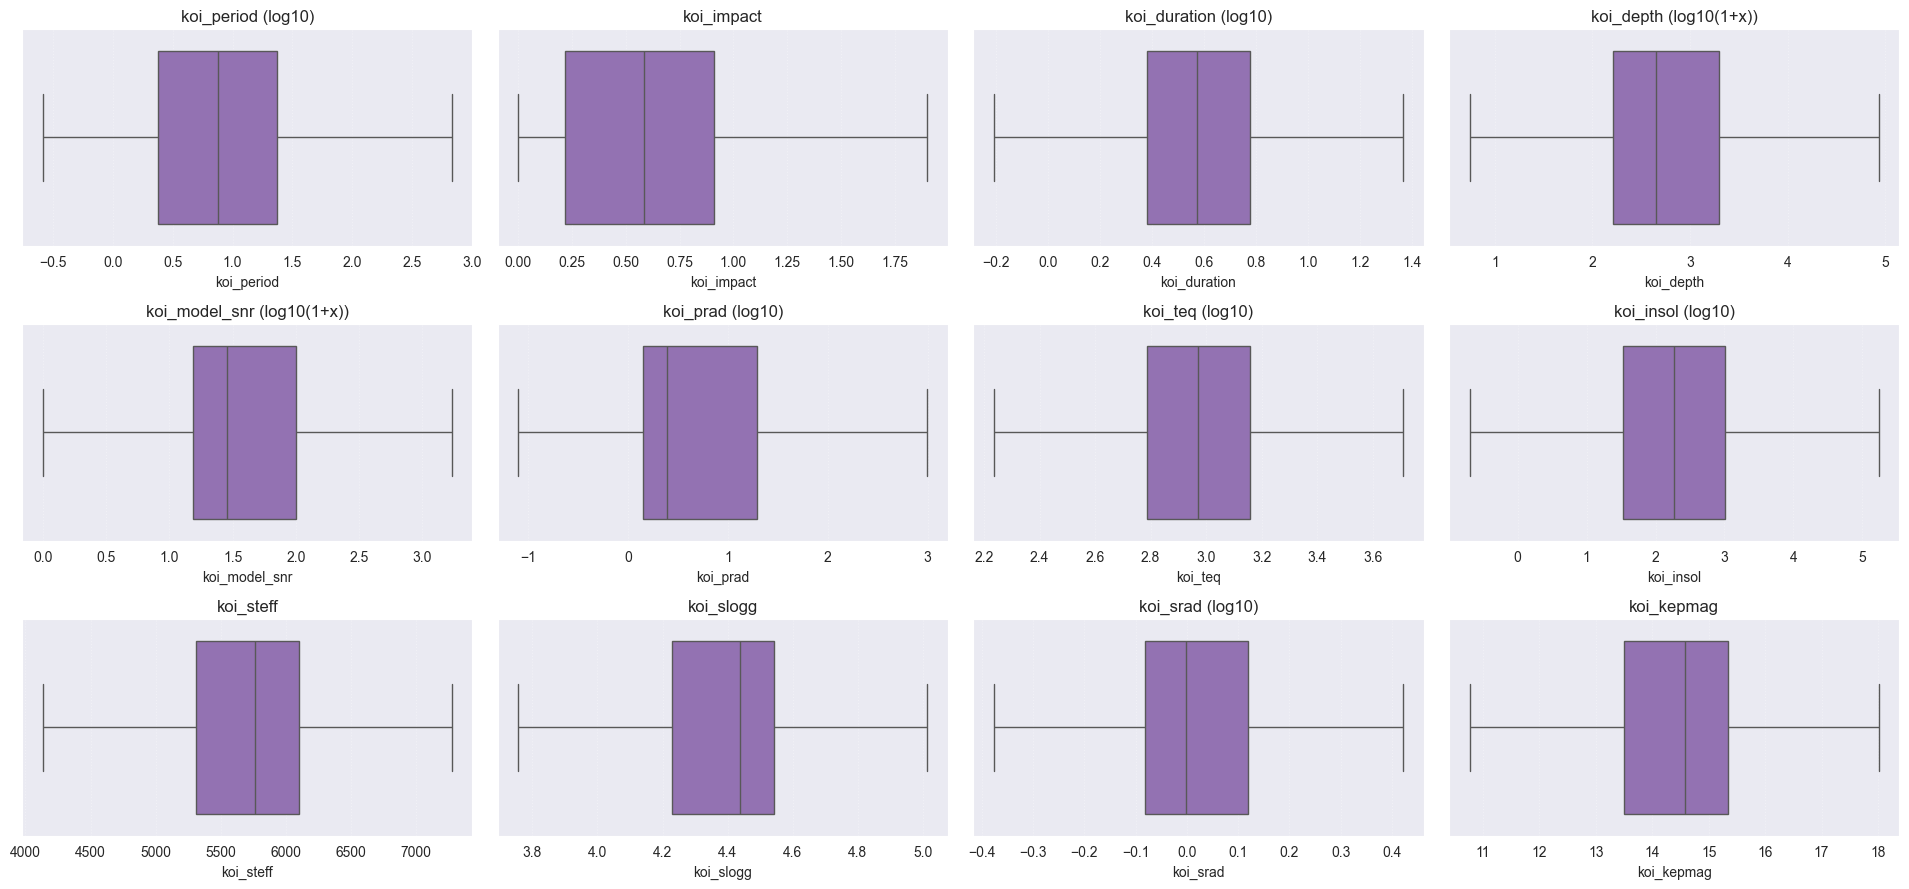

In [77]:
import math
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Use only the 12-feature vector (updated framework)
plot_cols = [c for c in FEATURE_COLS if c in df.columns]
# Identify discrete small-cardinality numeric columns to skip in box plots
discrete_small = [c for c in plot_cols if df[c].nunique(dropna=True) <= 5]
numeric_cols = [c for c in plot_cols if c not in discrete_small]

# Columns we keep linear due to physical meaning (bounded/magnitude)
never_log = {'koi_impact','koi_kepmag'}

log10_cols, log1p_cols, linear_cols = [], [], []
for col in numeric_cols:
    s = pd.to_numeric(df[col], errors='coerce').dropna()
    if col in never_log:
        linear_cols.append(col)
        continue
    if len(s) < 3:
        linear_cols.append(col)
        continue
    skew = float(s.skew())
    q95, q05 = s.quantile(0.95), s.quantile(0.05)
    ratio = (q95 / max(q05, 1e-12)) if q05 > 0 else np.inf
    criterion = (skew > 0.75) or (ratio > 20)
    minv = float(s.min())
    if criterion and minv > 0:
        log10_cols.append(col)
    elif criterion and minv >= 0:
        log1p_cols.append(col)
    else:
        linear_cols.append(col)

# Create transformed copy for plotting
plot_df = df.copy()
for col in log10_cols:
    plot_df[col] = np.log10(plot_df[col])
for col in log1p_cols:
    plot_df[col] = np.log10(plot_df[col] + 1.0)

print('Skipped discrete/binary columns:', discrete_small)
print('Log10 columns:', log10_cols)
print('Log10(1+x) columns:', log1p_cols)
print('Linear columns:', linear_cols)

# Plot box plots using transformed data where applicable
cols_to_plot = numeric_cols
ncols = 4
nrows = math.ceil(len(cols_to_plot) / ncols)
fig, axes = plt.subplots(nrows, ncols, figsize=(4.8 * ncols, 3.0 * nrows), squeeze=False)

for i, col in enumerate(cols_to_plot):
    r, c = divmod(i, ncols)
    ax = axes[r][c]
    sns.boxplot(x=plot_df[col].dropna(), ax=ax, color='#9467bd', orient='h', whis=1.5, showfliers=False)
    tr = ' (log10)' if col in log10_cols else (' (log10(1+x))' if col in log1p_cols else '')
    ax.set_title(col + tr)
    ax.grid(True, axis='x', linestyle=':', alpha=0.35)

# Hide unused axes
total_axes = nrows * ncols
for j in range(len(cols_to_plot), total_axes):
    r, c = divmod(j, ncols)
    axes[r][c].set_visible(False)

plt.tight_layout()
plt.show()


## Pre-PCA 12-feature table
This is the exact 12-D feature matrix X used for PCA and all models.

In [76]:
# Build the 12-feature matrix (order as in FEATURE_COLS)
X_cols = [c for c in FEATURE_COLS if c in df.columns]
X_12 = df[X_cols].copy()
print(f'X_12 shape: {X_12.shape}')
X_12.head()


X_12 shape: (8054, 12)


,koi_period,koi_impact,koi_duration,koi_depth,koi_model_snr,koi_prad,koi_teq,koi_insol,koi_steff,koi_slogg,koi_srad,koi_kepmag
0,9.488036,0.146,2.95750,615.8,35.8,2.26,793.0,93.59,5455.0,4.467,0.927,15.347
1,54.418383,0.586,4.50700,874.8,25.8,2.83,443.0,9.11,5455.0,4.467,0.927,15.347
2,19.899140,0.969,1.78220,10829.0,76.3,14.60,638.0,39.30,5853.0,4.544,0.868,15.436
3,1.736952,1.276,2.40641,8079.2,505.6,33.46,1395.0,891.96,5805.0,4.564,0.791,15.597
4,2.525592,0.701,1.65450,603.3,40.9,2.75,1406.0,926.16,6031.0,4.438,1.046,15.509


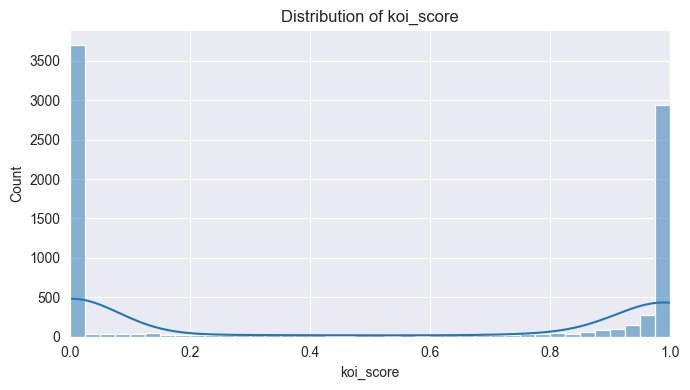

koi_score summary:
count    8054.000000
mean        0.480829
std         0.476928
min         0.000000
25%         0.000000
50%         0.334000
75%         0.998000
max         1.000000


In [78]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(7, 4))
ax = sns.histplot(df['koi_score'].dropna(), bins=40, kde=True, color='#1f77b4', edgecolor='white')
ax.set_title('Distribution of koi_score')
ax.set_xlabel('koi_score')
ax.set_ylabel('Count')
ax.set_xlim(0, 1)
plt.tight_layout()
plt.show()

print('koi_score summary:')
print(df['koi_score'].describe().to_string())
